## One-Dimensional Compaction

A one-dimensional MODFLOW 6 model was developed by Sneed (2008) to simulate
aquitard drainage, compaction and, land subsidence at the Holly site, located at
the Edwards Air Force base, in response to effective stress changes caused by
groundwater pumpage in the Antelope Valley in southern California.

### Initial setup

Import dependencies, define the example name and workspace, and read settings from environment variables.

In [1]:
import datetime
import os
import pathlib as pl

import flopy
import git
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pooch
from flopy.plot.styles import styles
from modflow_devtools.latex import build_table, exp_format, float_format, int_format
from modflow_devtools.misc import get_env, timed

# Example name and workspace paths. If this example is running
# in the git repository, use the folder structure described in
# the README. Otherwise just use the current working directory.
sim_name = "ex-gwf-csub-p03"
try:
    root = pl.Path(git.Repo(".", search_parent_directories=True).working_dir)
except:
    root = None
workspace = root / "examples" if root else pl.Path.cwd()
figs_path = root / "figures" if root else pl.Path.cwd()
tbls_path = root / "tables" if root else pl.Path.cwd()
data_path = root / "data" / sim_name if root else pl.Path.cwd()

# Settings from environment variables
write = get_env("WRITE", True)
run = get_env("RUN", True)
plot = get_env("PLOT", True)
plot_show = get_env("PLOT_SHOW", True)
plot_save = get_env("PLOT_SAVE", True)

### Define parameters

Define model units, parameters and other settings.

In [2]:
# Load the constant time series
fname = "boundary_heads.csv"
fpath = pooch.retrieve(
    url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
    fname=fname,
    path=data_path,
    known_hash="md5:8177e15feeeedcdd59ee15745e796e59",
)
csv_head = np.genfromtxt(fpath, names=True, delimiter=",")

# Reformat csv data into format for MODFLOW 6 timeseries file
chd_ts = []
for idx in range(csv_head.shape[0]):
    chd_ts.append(
        (
            csv_head["time"][idx],
            csv_head["CHD_L01"][idx],
            csv_head["CHD_L06"][idx],
            csv_head["CHD_L13"][idx],
        )
    )

# Simulation starting date and time
dstart = datetime.datetime(1907, 1, 1, 0, 0, 0)

# Create a datetime list for the simulation
date_list = [dstart + datetime.timedelta(days=x) for x in csv_head["time"]]

# Scenario parameters
parameters = {
    "ex-gwf-csub-p03a": {
        "head_based": True,
        "cg_ske": (
            0.00e0,
            0.00e0,
            0.00e0,
            0.00e0,
            5.42e-6,
            0.00e0,
            5.42e-6,
            0.00e0,
            0.00e0,
            0.00e0,
            0.00e0,
            5.42e-6,
            0.00e0,
            5.42e-6,
        ),
        "pcs0": (
            -4.91,
            -5.33,
            -5.76,
            -6.10,
            -6.10,
            -6.10,
            -6.10,
            -6.10,
            -6.71,
            -6.71,
            -6.10,
            -6.10,
            -6.71,
        ),
        "ssv": (
            6.6955e-4,
            6.6955e-4,
            6.6955e-4,
            1.2753e-4,
            1.2753e-4,
            1.2116e-3,
            1.2116e-3,
            1.2116e-3,
            1.2753e-4,
            1.2753e-4,
            4.7825e-4,
            4.7825e-4,
            4.7825e-4,
        ),
        "sse": (
            5.4202e-6,
            5.4202e-6,
            5.4202e-6,
            5.4202e-6,
            5.4202e-6,
            5.4202e-6,
            5.4202e-6,
            5.4202e-6,
            5.4202e-6,
            5.4202e-6,
            5.4202e-6,
            5.4202e-6,
            5.4202e-6,
        ),
    },
    "ex-gwf-csub-p03b": {
        "head_based": False,
        "cg_ske": (
            0.00e0,
            0.00e0,
            0.00e0,
            0.00e0,
            6.88e-6,
            0.00e0,
            6.88e-6,
            0.00e0,
            0.00e0,
            0.00e0,
            0.00e0,
            6.88e-6,
            0.00e0,
            6.88e-6,
        ),
        "pcs0": (
            47.27,
            55.93,
            62.76,
            75.90,
            98.15,
            103.33,
            111.86,
            117.35,
            285.60,
            339.25,
            75.90,
            285.60,
            339.25,
        ),
        "ssv": (
            1.3542e-3,
            1.3542e-3,
            1.3542e-3,
            2.6912e-4,
            2.7107e-4,
            1.9249e-3,
            1.9249e-3,
            1.9249e-3,
            1.4632e-4,
            2.1655e-4,
            2.2717e-4,
            4.8671e-4,
            1.0170e-3,
        ),
        "sse": (
            8.5697e-6,
            8.5697e-6,
            8.5697e-6,
            1.2559e-5,
            1.1538e-5,
            3.4235e-5,
            3.4235e-5,
            3.4235e-5,
            6.3990e-6,
            9.2419e-6,
            1.0292e-5,
            7.5887e-6,
            6.8638e-6,
        ),
    },
}

# Model units
length_units = "meters"
time_units = "days"

# Model parameters
nper = 353
nlay = 14
ncol = 1
nrow = 1
delr = 1.0
delc = 1.0
top = 0.0
botm = (
    -36.8811,
    -42.3676,
    -50.5973,
    -56.9981,
    -69.7998,
    -70.1046,
    -92.0504,
    -97.2321,
    -105.7666,
    -111.2530,
    -111.5578,
    -278.8945,
    -279.1993,
    -332.5398,
)
strt = (
    0.00,
    1.57,
    3.38,
    5.56,
    6.77,
    6.77,
    6.77,
    6.77,
    6.77,
    6.77,
    6.77,
    6.77,
    5.55,
    5.55,
)
icelltype = 0
k33 = (
    9.14e-3,
    3.66e-6,
    3.66e-6,
    3.66e-6,
    9.14e-3,
    9.14e-3,
    9.14e-3,
    4.57e-6,
    4.57e-6,
    4.57e-6,
    9.14e-3,
    9.14e-3,
    9.14e-3,
    9.14e-3,
)
iconvert = (1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0)
sgm = 1.7
sgs = 2.0
cg_theta = 0.3
ib_cellid = (
    (1, 0, 0),
    (2, 0, 0),
    (3, 0, 0),
    (4, 0, 0),
    (6, 0, 0),
    (7, 0, 0),
    (8, 0, 0),
    (9, 0, 0),
    (11, 0, 0),
    (13, 0, 0),
    (4, 0, 0),
    (11, 0, 0),
    (13, 0, 0),
)
ib_ctype = (
    "nodelay",
    "nodelay",
    "nodelay",
    "nodelay",
    "nodelay",
    "nodelay",
    "nodelay",
    "nodelay",
    "nodelay",
    "nodelay",
    "delay",
    "delay",
    "delay",
)
ib_thickness = (
    5.48649,
    8.22969,
    6.4008,
    2.7432,
    0.6096,
    5.1817,
    8.53449,
    5.4864,
    7.6201,
    0.9144,
    2.7432,
    3.0480,
    2.7432,
)
ib_rnb = (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.92, 1.66, 2.85)
ib_theta = 0.30
ib_kv = (
    999.0,
    999.0,
    999.0,
    999.0,
    999.0,
    999.0,
    999.0,
    999.0,
    999.0,
    999.0,
    4.57e-6,
    4.57e-6,
    4.57e-6,
)
ib_head = (
    999.0,
    999.0,
    999.0,
    999.0,
    999.0,
    999.0,
    999.0,
    999.0,
    999.0,
    999.0,
    6.77,
    6.77,
    5.55,
)
ib_name = (
    "CUNIT",
    "CUNIT",
    "CUNIT",
    "NODELAY",
    "NODELAY",
    "AQUITARD",
    "AQUITARD",
    "AQUITARD",
    "NODELAY",
    "NODELAY",
    "DELAY",
    "DELAY",
    "DELAY",
)

# Temporal discretization
tdis_ds = []
for idx in range(82):
    tdis_ds.append((365.25, 12, 1.0))
for idx in range(82, nper):
    tdis_ds.append((22.0, 22, 1.0))

# Constant head cells
c6 = []
for k, tag in zip((0, 5, 10, 12), ("upper", "middle", "middle", "lower")):
    c6.append([k, 0, 0, tag])

# Solver parameters
nouter = 200
ninner = 100
hclose = 1e-6
rclose = 1e-3
linaccel = "cg"
relax = 0.97

### Model setup

Define functions to build models, write input files, and run the simulation.

In [3]:
def build_models(
    name,
    subdir_name=".",
    head_based=True,
    cg_ske=1e-3,
    pcs0=0.0,
    ssv=1e-1,
    sse=1e-3,
):
    sim_ws = os.path.join(workspace, name)
    if subdir_name is not None:
        sim_ws = os.path.join(sim_ws, subdir_name)
    sim = flopy.mf6.MFSimulation(sim_name=name, sim_ws=sim_ws, exe_name="mf6")
    flopy.mf6.ModflowTdis(sim, nper=nper, perioddata=tdis_ds, time_units=time_units)
    flopy.mf6.ModflowIms(
        sim,
        print_option="summary",
        outer_maximum=nouter,
        outer_dvclose=hclose,
        linear_acceleration=linaccel,
        inner_maximum=ninner,
        inner_dvclose=hclose,
        relaxation_factor=relax,
        rcloserecord=f"{rclose} strict",
    )
    gwf = flopy.mf6.ModflowGwf(
        sim,
        modelname=name,
        save_flows=True,
    )
    flopy.mf6.ModflowGwfdis(
        gwf,
        length_units=length_units,
        nlay=nlay,
        nrow=nrow,
        ncol=ncol,
        delr=delr,
        delc=delc,
        top=top,
        botm=botm,
    )
    # gwf obs
    opth = f"{name}.gwf.obs"
    cpth = opth + ".csv"
    obs_array = []
    for k in range(nlay):
        obs_array.append([f"HD{k + 1:02d}", "HEAD", (k, 0, 0)])
    flopy.mf6.ModflowUtlobs(
        gwf,
        digits=10,
        print_input=True,
        filename=opth,
        continuous={cpth: obs_array},
    )

    flopy.mf6.ModflowGwfic(gwf, strt=strt)
    flopy.mf6.ModflowGwfnpf(
        gwf,
        icelltype=icelltype,
        k=k33,
        k33=k33,
        save_specific_discharge=True,
    )
    flopy.mf6.ModflowGwfsto(gwf, iconvert=iconvert, ss=0.0, sy=0, transient={0: True})
    if head_based:
        hb_bool = True
        tsgm = None
        tsgs = None
    else:
        hb_bool = None
        tsgm = sgm
        tsgs = sgs
    sub6 = []
    for idx, cdelay in enumerate(ib_ctype):
        sub6.append(
            [
                idx,
                ib_cellid[idx],
                cdelay,
                pcs0[idx],
                ib_thickness[idx],
                ib_rnb[idx],
                ssv[idx],
                sse[idx],
                ib_theta,
                ib_kv[idx],
                ib_head[idx],
                ib_name[idx],
            ]
        )
    csub = flopy.mf6.ModflowGwfcsub(
        gwf,
        print_input=True,
        save_flows=True,
        head_based=hb_bool,
        specified_initial_interbed_state=True,
        update_material_properties=True,
        ndelaycells=39,
        boundnames=True,
        beta=4.65120000e-10,
        gammaw=9806.65,
        ninterbeds=len(sub6),
        sgm=tsgm,
        sgs=tsgs,
        cg_theta=cg_theta,
        cg_ske_cr=cg_ske,
        packagedata=sub6,
    )
    opth = f"{name}.csub.obs"
    csub_csv = opth + ".csv"
    obs = [
        ("cunit1", "interbed-compaction", (0,)),
        ("cunit2", "interbed-compaction", (1,)),
        ("cunit3", "interbed-compaction", (2,)),
        ("aquitard6", "interbed-compaction", (5,)),
        ("aquitard7", "interbed-compaction", (6,)),
        ("aquitard8", "interbed-compaction", (7,)),
        ("nodelay4", "interbed-compaction", (3,)),
        ("nodelay5", "interbed-compaction", (4,)),
        ("nodelay9", "interbed-compaction", (8,)),
        ("nodelay10", "interbed-compaction", (9,)),
        ("delay11", "interbed-compaction", (10,)),
        ("delay12", "interbed-compaction", (11,)),
        ("delay13", "interbed-compaction", (12,)),
        ("es14", "estress-cell", (nlay - 1, 0, 0)),
    ]
    for k in (1, 2, 3, 4, 6, 7, 8, 9, 11, 13):
        tag = f"tc{k + 1:02d}"
        obs.append((tag, "compaction-cell", (k, 0, 0)))
        tag = f"skc{k + 1:02d}"
        obs.append((tag, "coarse-compaction", (k, 0, 0)))
    orecarray = {csub_csv: obs}
    csub.obs.initialize(
        filename=opth, digits=10, print_input=True, continuous=orecarray
    )

    chd = flopy.mf6.ModflowGwfchd(gwf, stress_period_data={0: c6})

    # initialize chd time series
    csubnam = f"{sim_name}.head.ts"
    chd.ts.initialize(
        filename=csubnam,
        timeseries=chd_ts,
        time_series_namerecord=["upper", "middle", "lower"],
        interpolation_methodrecord=["linear", "linear", "linear"],
        sfacrecord=["1.0", "1.0", "1.0"],
    )

    flopy.mf6.ModflowGwfoc(gwf, printrecord=[("BUDGET", "ALL")])
    return sim


def write_models(sim, silent=True):
    sim.write_simulation(silent=silent)


@timed
def run_models(sim, silent=True):
    success, buff = sim.run_simulation(silent=silent)
    assert success, buff

### Plotting results

Define functions to plot model results.

In [4]:
# Figure properties
xticks = (1907, 1917, 1927, 1937, 1947, 1957, 1967, 1977, 1987, 1997, 2007)
s = (
    "01-01-1907",
    "01-01-1917",
    "01-01-1927",
    "01-01-1937",
    "01-01-1947",
    "01-01-1957",
    "01-01-1967",
    "01-01-1977",
    "01-01-1987",
    "01-01-1997",
    "01-01-2007",
)

df_xticks = [datetime.datetime.strptime(ss, "%m-%d-%Y").date() for ss in s]
df_xticks1 = [
    datetime.datetime.strptime(f"{yr:04d}-01-01", "%Y-%m-%d").date()
    for yr in range(1990, 2007)
]

pcomp = (
    "TOTAL",
    "AQUITARD",
    "DELAY",
    "CUNIT",
    "NODELAY",
    "SKELETAL",
)
clabels = (
    "Total compaction",
    "Thick aquitard compaction",
    "Delay interbed compaction",
    "Confining unit compaction",
    "No-delay interbed compaction",
    "Elastic coarse-grained material compaction",
)
llabels = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13)

zelevs = [top]
edges = [(0, 0)]
for z in botm:
    zelevs.append(z)
    edges.append((-z, -z))

figure_size = (6.8, 3.4)
arrow_props = dict(facecolor="black", arrowstyle="-", lw=0.5)


def export_tables(silent=True):
    if plot_save:
        name = list(parameters.keys())[1]

        caption = f"Aquifer properties for example {sim_name}."
        headings = (
            "Layer",
            "Thickness",
            "Hydraulic conductivity",
            "Initial head",
        )
        fpth = tbls_path / f"{sim_name}-01.tex"
        dtype = [
            ("k", "U30"),
            ("thickness", "U30"),
            ("k33", "U30"),
            ("h0", "U30"),
        ]
        arr = np.zeros(nlay, dtype=dtype)
        for k in range(nlay):
            arr["k"][k] = int_format(k + 1)
            arr["thickness"][k] = float_format(zelevs[k] - zelevs[k + 1])
            arr["k33"][k] = exp_format(k33[k])
            arr["h0"][k] = float_format(strt[k])
        if not silent:
            print(f"creating...'{fpth}'")
        col_widths = (0.1, 0.15, 0.30, 0.25)
        build_table(caption, fpth, arr, headings=headings, col_widths=col_widths)

        caption = f"Interbed properties for example {sim_name}."
        headings = (
            "Interbed",
            "Layer",
            "Thickness",
            "Initial stress",
        )
        fpth = tbls_path / f"{sim_name}-02.tex"
        dtype = [
            ("ib", "U30"),
            ("k", "U30"),
            ("thickness", "U30"),
            ("pcs0", "U30"),
        ]
        arr = np.zeros(len(ib_ctype), dtype=dtype)
        for idx, ctype in enumerate(ib_ctype):
            arr["ib"][idx] = int_format(idx + 1)
            arr["k"][idx] = int_format(ib_cellid[idx][0] + 1)
            if ctype == "nodelay":
                arr["thickness"][idx] = float_format(ib_thickness[idx])
            else:
                b = ib_thickness[idx] * ib_rnb[idx]
                arr["thickness"][idx] = float_format(b)
            arr["pcs0"][idx] = float_format(parameters[name]["pcs0"][idx])
        if not silent:
            print(f"creating...'{fpth}'")
        build_table(caption, fpth, arr, headings=headings)

        caption = f"Aquifer storage properties for example {sim_name}."
        headings = (
            "Layer",
            "Specific Storage",
        )
        fpth = tbls_path / f"{sim_name}-03.tex"
        dtype = [("k", "U30"), ("ss", "U30")]
        arr = np.zeros(4, dtype=dtype)
        for idx, k in enumerate((4, 6, 11, 13)):
            arr["k"][idx] = int_format(k + 1)
            arr["ss"][idx] = exp_format(parameters[name]["cg_ske"][k])
        if not silent:
            print(f"creating...'{fpth}'")
        col_widths = (0.1, 0.25)
        build_table(caption, fpth, arr, headings=headings, col_widths=col_widths)

        caption = f"Interbed storage properties for example {sim_name}."
        headings = (
            "Interbed",
            "Layer",
            "Inelastic \\newline Specific \\newline Storage",
            "Elastic \\newline Specific \\newline Storage",
        )
        fpth = tbls_path / f"{sim_name}-04.tex"
        dtype = [
            ("ib", "U30"),
            ("k", "U30"),
            ("ssv", "U30"),
            ("sse", "U30"),
        ]
        arr = np.zeros(len(ib_ctype), dtype=dtype)
        for idx, ctype in enumerate(ib_ctype):
            arr["ib"][idx] = int_format(idx + 1)
            arr["k"][idx] = int_format(ib_cellid[idx][0] + 1)
            arr["ssv"][idx] = exp_format(parameters[name]["ssv"][idx])
            arr["sse"][idx] = exp_format(parameters[name]["sse"][idx])
        if not silent:
            print(f"creating...'{fpth}'")
        col_widths = (0.2, 0.2, 0.2, 0.2)
        build_table(
            caption,
            fpth,
            arr,
            headings=headings,
            col_widths=col_widths,
        )


def get_obs_dataframe(file_name, hash):
    fpath = pooch.retrieve(
        url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{file_name}",
        fname=file_name,
        path=data_path,
        known_hash=f"md5:{hash}",
    )
    df = pd.read_csv(fpath, index_col=0)
    df.index = pd.to_datetime(df.index.values, format="%m/%d/%y")
    df.rename({"mean": "observed"}, inplace=True, axis=1)
    return df


def process_sim_csv(
    fpth, index_tag="time", origin_str="1908-05-09 00:00:00.000000", **kwargs
):
    v = pd.read_csv(fpth, **kwargs)

    v["date"] = pd.to_datetime(v[index_tag].values, unit="d", origin=origin_str)
    v.set_index("date", inplace=True)
    v.drop(columns=index_tag, inplace=True)

    col_list = list(v.columns)

    return v, col_list


def get_sim_dataframe(fpth, index_tag="time", origin_str="1908-05-09 00:00:00.000000"):
    v, col_list = process_sim_csv(fpth, index_tag=index_tag, origin_str=origin_str)

    # calculate total skeletal and total
    shape = v[col_list[0]].values.shape[0]
    s = np.zeros(shape, dtype=float)
    # skeletal
    for tag in col_list:
        if "SKC" in tag[:3]:
            s += v[tag].values
    v["SKELETAL"] = s.copy()
    # total
    s[:] = 0.0
    for tag in col_list:
        if "TC" in tag[:2]:
            s += v[tag].values
    v["TOTAL"] = s.copy()

    for tag in col_list:
        if "TC" in tag[:2] or "SKC" in tag[:3]:
            v.drop(columns=tag, inplace=True)
    return v


def dataframe_interp(df_in, new_index):
    df_out = pd.DataFrame(index=new_index)
    df_out.index.name = df_in.index.name

    for colname, col in df_in.items():
        df_out[colname] = np.interp(new_index, df_in.index, col)

    return df_out


def process_csub_obs(fpth):
    tdata = flopy.utils.Mf6Obs(fpth).data
    dtype = [
        ("totim", float),
        ("CUNIT", float),
        ("AQUITARD", float),
        ("NODELAY", float),
        ("DELAY", float),
        ("SKELETAL", float),
        ("TOTAL", float),
    ]

    # create structured array and fill time
    v = np.zeros(tdata.shape[0], dtype=dtype)
    v["totim"] = tdata["totim"]
    v["totim"] /= 365.25
    v["totim"] += 1908.353182752

    # transfer data from temporary storage
    for key in pcomp:
        if key != "TOTAL" and key != "SKELETAL":
            for obs_key in tdata.dtype.names:
                if key in obs_key:
                    v[key] += tdata[obs_key]

    # calculate skeletal
    for key in tdata.dtype.names[1:]:
        if "SKC" in key[:3]:
            v["SKELETAL"] += tdata[key]

    # calculate total
    for key in tdata.dtype.names[1:]:
        if "TC" in key[:2]:
            v["TOTAL"] += tdata[key]

    return v


def set_label(label, text="text"):
    if label == "":
        label = text
    else:
        label = None
    return label


def print_label(ax, zelev, k, fontsize=6):
    zmax = zelev[-1][0]
    z0 = zelev[k][0]
    z1 = zelev[k + 1][0]
    z = 1 - 0.5 * (z0 + z1) / zmax
    text = f"Layer {k + 1}"
    if k == 10:
        arrowprops = dict(
            facecolor="black",
            arrowstyle="-",
            lw=0.5,
            connectionstyle="angle,angleA=-90,angleB=180,rad=0",
            shrinkA=0,
            shrinkB=0,
        )
        ax.annotate(
            text,
            xy=(1, z),
            xytext=(1.01, z - 0.025),
            ha="left",
            va="top",
            zorder=103,
            xycoords="axes fraction",
            textcoords="axes fraction",
            arrowprops=arrowprops,
            fontsize=fontsize,
        )
    else:
        ax.text(
            1.01,
            z,
            text,
            fontsize=fontsize,
            ha="left",
            va="center",
            transform=plt.gca().transAxes,
            zorder=103,
        )
    return


def constant_heads(ax, annotate=False, fontsize=6, xrange=(0, 1)):
    arrowprops = dict(facecolor="black", arrowstyle="-", lw=0.5, shrinkA=0, shrinkB=0)
    label = ""
    for k in [0, 5, 10, 12]:
        label = set_label(label, text="Constant head")
        color = "cyan"
        if k == 0:
            zo = 1
            lw = 0.5
        else:
            zo = 200
            lw = 0.5
        ax.fill_between(
            xrange,
            edges[k],
            y2=edges[k + 1],
            color=color,
            lw=lw,
            label=label,
            zorder=zo,
        )
        if annotate:
            text = "Constant\nhead"
            x = 47.5
            if k == 0:
                y = 0.5 * (edges[k][0] + edges[k + 1][0])
                ax.text(
                    x, y, text, fontsize=fontsize, ha="center", va="center", zorder=203
                )
            else:
                y = edges[k + 1][0]
                ax.annotate(
                    text,
                    xy=(x + 2.25, y),
                    xytext=(x, y + 5),
                    ha="center",
                    va="top",
                    zorder=203,
                    arrowprops=arrowprops,
                    fontsize=fontsize,
                )

    return


def plot_grid(silent=True):
    with styles.USGSMap():
        # # load the model
        # sim = flopy.mf6.MFSimulation.load(sim_name=name, sim_ws=sim_ws)
        # gwf = sim.get_model(name)

        xrange = (0, 1)
        chds = (5, 10, 12)

        fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(5.1, 4.0))
        plt.subplots_adjust(wspace=1)

        for idx, ax in enumerate(axes):
            ax.set_xlim(xrange)
            ax.set_ylim(edges[-1][0], 0)
            for edge in edges:
                ax.plot(xrange, edge, lw=0.5, color="black")
            ax.tick_params(
                axis="x", which="both", bottom=False, top=False, labelbottom=False
            )
            ax.tick_params(axis="y", which="both", right=False, labelright=False)

        ax = axes[0]
        ax.fill_between(
            xrange, edges[0], y2=edges[1], color="green", lw=0, label="Upper aquifer"
        )

        label = ""
        for k in (1, 2, 3):
            label = set_label(label, text="Confining unit")
            ax.fill_between(
                xrange, edges[k], y2=edges[k + 1], color="brown", lw=0, label=label
            )

        label = ""
        for k in (7, 8, 9):
            label = set_label(label, text="Thick aquitard")
            ax.fill_between(
                xrange, edges[k], y2=edges[k + 1], color="tan", lw=0, label=label
            )

        # middle aquifer
        midz = 825.0 / 3.8081
        midz = [edges[4], edges[7], edges[10], (midz, midz)]
        ax.fill_between(
            xrange, midz[0], y2=midz[1], color="cyan", lw=0, label="Middle aquifer"
        )
        ax.fill_between(xrange, midz[2], y2=midz[3], color="cyan", lw=0)

        # lower aquifer
        ax.fill_between(
            xrange, midz[-1], y2=edges[-1], color="blue", lw=0, label="Lower aquifer"
        )

        styles.graph_legend(ax, loc="lower right", frameon=True, framealpha=1)
        styles.heading(ax=ax, letter="A", heading="Hydrostratigraphy")
        styles.remove_edge_ticks(ax)
        ax.set_ylabel("Depth below land\nsurface, in meters")

        # csub interbeds
        ax = axes[1]

        nodelay = (1, 2, 3, 6, 7, 8, 9)
        label = ""
        for k in nodelay:
            label = set_label(label, text="No-delay")
            ax.fill_between(
                xrange, edges[k], y2=edges[k + 1], color="0.5", lw=0, label=label
            )

        comb = [4, 11, 13]
        label = ""
        for k in comb:
            label = set_label(label, text="No-delay\nand delay")
            ax.fill_between(
                xrange, edges[k], y2=edges[k + 1], color="brown", lw=0, label=label
            )

        for k in chds:
            ax.fill_between(
                xrange, edges[k], y2=edges[k + 1], color="white", lw=0.75, zorder=100
            )

        leg = styles.graph_legend(ax, loc="lower right", frameon=True, framealpha=1)
        leg.set_zorder(100)
        styles.heading(ax=ax, letter="B", heading="Interbed types")
        styles.remove_edge_ticks(ax)

        # boundary conditions
        ax = axes[2]
        constant_heads(ax)

        for k in llabels:
            print_label(ax, edges, k)

        styles.graph_legend(ax, loc="lower left", frameon=True)
        styles.heading(ax=ax, letter="C", heading="Boundary conditions")
        styles.remove_edge_ticks(ax)

        fig.tight_layout(pad=0.5)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-grid.png"
            if not silent:
                print(f"saving...'{fpth}'")
            fig.savefig(fpth)


def plot_boundary_heads(silent=True):
    with styles.USGSPlot():

        def process_dtw_obs(fpth):
            v = flopy.utils.Mf6Obs(fpth).data
            v["totim"] /= 365.25
            v["totim"] += 1908.353182752
            for key in v.dtype.names[1:]:
                v[key] *= -1.0
            return v

        name = next(iter(parameters.keys()))
        pth = os.path.join(workspace, name, f"{name}.gwf.obs.csv")
        hdata = process_dtw_obs(pth)

        pheads = ("HD01", "HD12", "HD14")
        hlabels = ("Upper aquifer", "Middle aquifer", "Lower aquifer")
        hcolors = ("green", "cyan", "blue")

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.8, 6.8 / 3))

        ax.set_xlim(1907, 2007)
        ax.set_xticks(xticks)
        ax.set_ylim(50.0, -10.0)
        ax.set_yticks(sorted([50.0, 40.0, 30.0, 20.0, 10.0, 0.0, -10.0]))

        ax.plot([1907, 2007], [0, 0], lw=0.5, color="0.5")
        for idx, key in enumerate(pheads):
            ax.plot(
                hdata["totim"],
                hdata[key],
                lw=0.75,
                color=hcolors[idx],
                label=hlabels[idx],
            )

        styles.graph_legend(ax=ax, frameon=False)
        ax.set_ylabel(f"Depth to water, in {length_units}")
        ax.set_xlabel("Year")

        styles.remove_edge_ticks(ax=ax)

        fig.tight_layout()

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-01.png"
            if not silent:
                print(f"saving...'{fpth}'")
            fig.savefig(fpth)


def plot_head_es_comparison(silent=True):
    with styles.USGSPlot() as fs:
        name = next(iter(parameters.keys()))
        pth = os.path.join(workspace, name, f"{name}.csub.obs.csv")
        hb = process_csub_obs(pth)

        name = list(parameters.keys())[1]
        pth = os.path.join(workspace, name, f"{name}.csub.obs.csv")
        es = process_csub_obs(pth)

        ymin = (2.0, 1, 1, 1, 0.1, 0.1)

        me = {}
        for idx, key in enumerate(pcomp):
            v = (es[key] - hb[key]).mean()
            me[key] = v

        fig, axes = plt.subplots(nrows=6, ncols=1, sharex=True, figsize=(6.8, 4.7))
        for idx, key in enumerate(pcomp):
            label = clabels[idx]
            ax = axes[idx]
            ax.set_xlim(1907, 2007)
            ax.set_ylim(0, ymin[idx])
            ax.set_xticks(xticks)
            stext = "none"
            otext = "none"
            if idx == 0:
                stext = "Effective stress-based"
                otext = "Head-based"
            mtext = f"mean error = {me[key]:7.4f} {length_units}"
            ax.plot(hb["totim"], hb[key], color="#238A8DFF", lw=1.25, label=otext)
            ax.plot(
                es["totim"], es[key], color="black", lw=0.75, label=stext, zorder=101
            )
            ltext = chr(ord("A") + idx)
            htext = f"{label}"
            styles.heading(ax, letter=ltext, heading=htext)
            va = "bottom"
            ym = 0.15
            if idx in [2, 3]:
                va = "top"
                ym = 0.85
            ax.text(
                0.99, ym, mtext, ha="right", va=va, transform=ax.transAxes, fontsize=7
            )
            styles.remove_edge_ticks(ax=ax)
            if idx == 0:
                styles.graph_legend(ax, loc="center left", ncol=2)
            if idx == 5:
                ax.set_xlabel("Year")

        axp1 = fig.add_subplot(1, 1, 1, frameon=False)
        axp1.tick_params(
            labelcolor="none", top="off", bottom="off", left="off", right="off"
        )
        axp1.set_xlim(0, 1)
        axp1.set_xticks([0, 1])
        axp1.set_ylim(0, 1)
        axp1.set_yticks([0, 1])
        axp1.set_ylabel(f"Compaction, in {length_units}")
        axp1.yaxis.set_label_coords(-0.05, 0.5)
        styles.remove_edge_ticks(ax)

        fig.tight_layout(pad=0.0001)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-02.png"
            if not silent:
                print(f"saving...'{fpth}'")
            fig.savefig(fpth)


def plot_calibration(silent=True):
    with styles.USGSPlot():
        name = list(parameters.keys())[1]
        fpath = os.path.join(workspace, name, f"{name}.csub.obs.csv")
        df_sim = get_sim_dataframe(fpath)
        for key in pcomp:
            df_sim[key] = df_sim[list(df_sim.filter(regex=key))].sum(axis=1)
        df_sim.rename({"TOTAL": "simulated"}, inplace=True, axis=1)

        fname = "boundary_heads.csv"
        fpath = pooch.retrieve(
            url=f"https://github.com/MODFLOW-USGS/modflow6-examples/raw/master/data/{sim_name}/{fname}",
            fname=fname,
            path=data_path,
            known_hash="md5:8177e15feeeedcdd59ee15745e796e59",
        )
        df_obs_heads, col_list = process_sim_csv(fpath)

        ccolors = (
            "black",
            "tan",
            "cyan",
            "brown",
            "blue",
            "violet",
        )

        xf0 = datetime.datetime(1907, 1, 1, 0, 0, 0)
        xf1 = datetime.datetime(2007, 1, 1, 0, 0, 0)
        xf0s = datetime.datetime(1990, 1, 1, 0, 0, 0)
        xf1s = datetime.datetime(2007, 1, 1, 0, 0, 0)
        xc0 = datetime.datetime(1992, 10, 1, 0, 0, 0)
        xc1 = datetime.datetime(2006, 9, 4, 0, 0, 0)
        dx = xc1 - xc0
        xca = xc0 + dx / 2

        # get observation data
        df = get_obs_dataframe(
            file_name="008N010W01Q005S_obs.csv", hash="96dd2d0f0eca8c0293275bf87073547e"
        )
        ix0 = df.index.get_loc("2006-09-04 00:00:00")
        offset = df_sim["simulated"].values[-1] - df.observed.values[ix0]
        df.observed += offset

        # -- subplot a -----------------------------------------------------------
        # build box for subplot B
        o = datetime.timedelta(31)
        ix = (xf0s, xf0s, xf1s - o, xf1s - o, xf0s)
        iy = (1.15, 1.45, 1.45, 1.15, 1.15)
        # -- subplot a -----------------------------------------------------------

        # -- subplot c -----------------------------------------------------------
        # get observations
        df_pc = get_obs_dataframe(
            file_name="008N010W01Q005S_1D.csv", hash="167f83f51692165394442b0eb1fec45e"
        )

        # get index for start of calibration period for subplot c
        ix0 = df_sim.index.get_loc("1992-10-01 12:00:00")

        # get initial simulated compaction
        cstart = df_sim.simulated.iloc[ix0]

        # cut off initial portion of simulated compaction
        df_sim_pc = df_sim[ix0:].copy()

        # reset initial compaction to 0.
        df_sim_pc.simulated -= cstart

        # reset simulated so maximum compaction is the same
        offset = df_pc.observed.values.max() - df_sim_pc.simulated.values[-1]
        df_sim.simulated += offset

        # interpolate subsidence observations to the simulation index for subplot c
        df_iobs_pc = dataframe_interp(df_pc, df_sim_pc.index)

        # truncate head to start of observations
        head_pc = dataframe_interp(df_obs_heads, df_sim_pc.index)

        # calculate geostatic stress
        gs = sgm * (0.0 - head_pc.CHD_L01.values) + sgs * (
            head_pc.CHD_L01.values - botm[-1]
        )

        # calculate hydrostatic stress for subplot c
        u = head_pc.CHD_L13.values - botm[-1]

        # calculate effective stress
        es_obs = gs - u

        # set up indices for date text for plot c
        locs = [f"{yr:04d}-10-01 12:00:00" for yr in range(1992, 2006)]
        locs += [f"{yr:04d}-04-01 12:00:00" for yr in range(1993, 2007)]
        locs += ["2006-09-04 12:00:00"]

        ixs = [head_pc.index.get_loc(loc) for loc in locs]
        # -- subplot c -----------------------------------------------------------

        ctext = "Calibration period\n{} to {}".format(
            xc0.strftime("%B %d, %Y"), xc1.strftime("%B %d, %Y")
        )

        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6.8, 6.8))

        # -- plot a --------------------------------------------------------------
        ax = axes.flat[0]
        ax.set_xlim(xf0, xf1)
        ax.plot([xf0, xf1], [0, 0], lw=0.5, color="0.5")
        ax.plot(
            [xf0],
            [-10],
            marker=".",
            ms=1,
            lw=0,
            color="red",
            label="Holly site (8N/10W-1Q)",
        )
        for idx, key in enumerate(pcomp):
            if key == "TOTAL":
                key = "simulated"
            color = ccolors[idx]
            label = clabels[idx]
            ax.plot(
                df_sim.index.values,
                df_sim[key].values,
                color=color,
                label=label,
                lw=0.75,
            )
        ax.plot(ix, iy, lw=1.0, color="red", zorder=200)
        styles.add_text(ax=ax, text="B", x=xf0s, y=1.14, transform=False)

        ax.set_ylim(1.5, -0.1)
        ax.xaxis.set_ticks(df_xticks)
        ax.xaxis.set_major_formatter(mpl.dates.DateFormatter("%m/%d/%Y"))

        ax.set_ylabel(f"Compaction, in {length_units}")
        ax.set_xlabel("Year")

        styles.graph_legend(ax=ax, frameon=False)
        styles.heading(ax, letter="A")
        styles.remove_edge_ticks(ax=ax)

        # -- plot b --------------------------------------------------------------
        ax = axes.flat[1]
        ax.set_xlim(xf0s, xf1s)
        ax.set_ylim(1.45, 1.15)
        ax.plot(
            df.index.values, df["observed"].values, marker=".", ms=1, lw=0, color="red"
        )
        ax.plot(
            df_sim.index.values,
            df_sim["simulated"].values,
            color="black",
            label=label,
            lw=0.75,
        )

        # plot lines for calibration
        ax.plot([xc0, xc0], [1.45, 1.15], color="black", lw=0.5, ls=":")
        ax.plot([xc1, xc1], [1.45, 1.15], color="black", lw=0.5, ls=":")
        styles.add_annotation(
            ax=ax,
            text=ctext,
            italic=False,
            bold=False,
            xy=(xc0 - o, 1.2),
            xytext=(xca, 1.2),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="-|>", fc="black", lw=0.5),
            color="none",
            bbox=dict(boxstyle="square,pad=-0.07", fc="none", ec="none"),
        )
        styles.add_annotation(
            ax=ax,
            text=ctext,
            italic=False,
            bold=False,
            xy=(xc1 + o, 1.2),
            xytext=(xca, 1.2),
            ha="center",
            va="center",
            arrowprops=dict(arrowstyle="-|>", fc="black", lw=0.5),
            bbox=dict(boxstyle="square,pad=-0.07", fc="none", ec="none"),
        )

        ax.yaxis.set_ticks(np.linspace(1.15, 1.45, 7))
        ax.xaxis.set_ticks(df_xticks1)

        ax.xaxis.set_major_locator(mpl.dates.YearLocator())
        ax.xaxis.set_minor_locator(mpl.dates.YearLocator(month=6, day=15))

        ax.xaxis.set_major_formatter(mpl.ticker.NullFormatter())
        ax.xaxis.set_minor_formatter(mpl.dates.DateFormatter("%Y"))
        ax.tick_params(axis="x", which="minor", length=0)

        ax.set_ylabel(f"Compaction, in {length_units}")
        ax.set_xlabel("Year")
        styles.heading(ax, letter="B")
        styles.remove_edge_ticks(ax=ax)

        # -- plot c --------------------------------------------------------------
        ax = axes.flat[2]
        ax.set_xlim(-0.01, 0.2)
        ax.set_ylim(368, 376)

        ax.plot(
            df_iobs_pc.observed.values,
            es_obs,
            marker=".",
            ms=1,
            color="red",
            lw=0,
            label="Holly site (8N/10W-1Q)",
        )
        ax.plot(
            df_sim_pc.simulated.values,
            df_sim_pc.ES14.values,
            color="black",
            lw=0.75,
            label="Simulated",
        )

        for idx, ixc in enumerate(ixs):
            text = f"{df_iobs_pc.index[ixc]:%m/%d/%Y}"
            if df_iobs_pc.index[ixc].month == 4:
                dxc = -0.001
                dyc = -1
            elif df_iobs_pc.index[ixc].month == 9:
                dxc = 0.002
                dyc = 0.75
            else:
                dxc = 0.001
                dyc = 1
            xc = df_iobs_pc.observed.iloc[ixc]
            yc = es_obs[ixc]
            styles.add_annotation(
                ax=ax,
                text=text,
                italic=False,
                bold=False,
                xy=(xc, yc),
                xytext=(xc + dxc, yc + dyc),
                ha="center",
                va="center",
                fontsize=7,
                arrowprops=dict(arrowstyle="-", color="red", fc="red", lw=0.5),
                bbox=dict(boxstyle="square,pad=-0.15", fc="none", ec="none"),
            )

        xtext = "Total compaction since {}, in {}".format(
            df_sim_pc.index[0].strftime("%B %d, %Y"), length_units
        )
        ytext = (
            "Effective stress at the bottom of\n"
            f"the lower aquifer, in {length_units} of water"
        )
        ax.set_xlabel(xtext)
        ax.set_ylabel(ytext)
        styles.heading(ax, letter="C")
        styles.remove_edge_ticks(ax=ax)
        styles.remove_edge_ticks(ax)

        # finalize figure
        fig.tight_layout(pad=0.01)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-03.png"
            if not silent:
                print(f"saving...'{fpth}'")
            fig.savefig(fpth)


def plot_vertical_head(silent=True):
    with styles.USGSPlot() as fs:
        name = list(parameters.keys())[1]
        pth = os.path.join(workspace, name, f"{name}.gwf.obs.csv")
        df_heads, col_list = process_sim_csv(
            pth, origin_str="1908-05-09 00:00:00.000000"
        )
        df_heads_year = df_heads.groupby(df_heads.index.year).mean()

        def get_colors(vmax=6):
            # set color
            cmap = plt.get_cmap("viridis")
            cNorm = mpl.colors.Normalize(vmin=0, vmax=vmax)
            scalarMap = mpl.cm.ScalarMappable(norm=cNorm, cmap=cmap)
            colors = []
            for ic in range(vmax):
                colors.append(scalarMap.to_rgba(ic))
            return colors

        def build_head_data(df, year=1908):
            dfr = df.loc[df.index == year]
            xlabel = None
            x = []
            y = []
            for k in range(14):
                tag = f"HD{k + 1:02d}"
                h = dfr[tag].values[0]
                if k == 0:
                    z0 = -25.0
                    xlabel = -1.0 * h
                else:
                    z0 = zelevs[k]
                z1 = zelevs[k + 1]
                h *= -1.0
                x += [h, h]
                y += [-z0, -z1]
            return xlabel, x, y

        iyears = (1908, 1916, 1926, 1936, 1946, 1956, 1966, 1976, 1986, 1996, 2006)
        colors = get_colors(vmax=len(iyears) - 1)

        xrange = (-10, 50)
        fig, ax = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(0.75 * 6.8, 4.0))

        ax.set_xlim(xrange)
        ax.set_ylim(-botm[-1], 0)

        for z in botm:
            ax.axhline(y=-z, xmin=-30, xmax=160, lw=0.5, color="0.5")

        # add confining units
        label = ""
        for k in (1, 2, 3):
            label = set_label(label, text="Confining unit")
            ax.fill_between(
                xrange, edges[k], y2=edges[k + 1], color="brown", lw=0, label=label
            )
        ypos = -0.5 * (zelevs[2] + zelevs[3])
        ax.text(
            40, ypos, "Confining unit", ha="left", va="center", size=8, color="white"
        )

        label = ""
        for k in (7, 8, 9):
            label = set_label(label, text="Thick aquitard")
            ax.fill_between(
                xrange, edges[k], y2=edges[k + 1], color="tan", lw=0, label=label
            )
        ypos = -0.5 * (zelevs[8] + zelevs[9])
        ax.text(
            40, ypos, "Thick aquitard", ha="left", va="center", size=8, color="white"
        )

        zo = 105
        for idx, iyear in enumerate(iyears[:-1]):
            xlabel, x, y = build_head_data(df_heads_year, year=iyear)
            xlabel1, x1, y1 = build_head_data(df_heads_year, year=iyears[idx + 1])
            ax.fill_betweenx(
                y, x, x2=x1, color=colors[idx], zorder=zo, step="mid", lw=0
            )
            ax.plot(x, y, lw=0.5, color="black", zorder=201)
            ax.text(
                xlabel, 24, f"{iyear}", ha="center", va="bottom", rotation=90, size=7
            )
            if iyear == 1996:
                ax.plot(x1, y1, lw=0.5, color="black", zorder=zo)
                ax.text(
                    xlabel1,
                    24,
                    f"{iyears[idx + 1]}",
                    ha="center",
                    va="bottom",
                    rotation=90,
                    size=7,
                )
            zo += 1

        # add layer labels
        for k in llabels:
            print_label(ax, edges, k)

        constant_heads(ax, annotate=True, xrange=xrange)

        ax.set_xlabel("Depth to water, in meters below land surface")
        ax.set_ylabel("Depth below land surface, in meters")

        styles.remove_edge_ticks(ax)

        fig.tight_layout(pad=0.5)

        if plot_show:
            plt.show()
        if plot_save:
            fpth = figs_path / f"{sim_name}-04.png"
            if not silent:
                print(f"saving...'{fpth}'")
            fig.savefig(fpth)


def plot_results(silent=True):
    if not plot:
        return
    plot_grid(silent=silent)
    plot_boundary_heads(silent=silent)
    plot_head_es_comparison(silent=silent)
    plot_calibration(silent=silent)
    plot_vertical_head()

### Running the example

Define and invoke a function to run the example scenarios, then plot results.

In [5]:
def scenario(idx, silent=True):
    key = list(parameters.keys())[idx]
    params = parameters[key].copy()
    sim = build_models(key, **params)
    if write:
        write_models(sim, silent=silent)
    if run:
        run_models(sim, silent=silent)

Run the head based solution.

In [6]:
scenario(0)

run_models took 11011.04 ms


Run the effective stress solution.

In [7]:
scenario(1)

run_models took 11241.10 ms


Plot results and export tables.

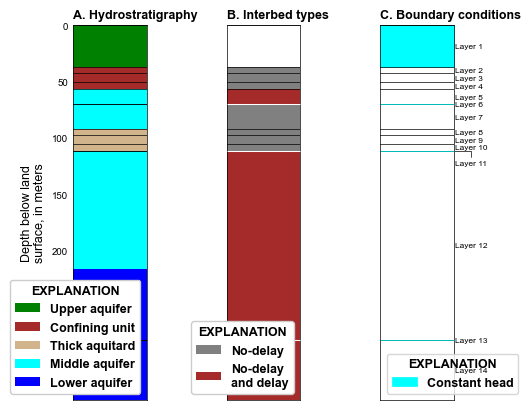

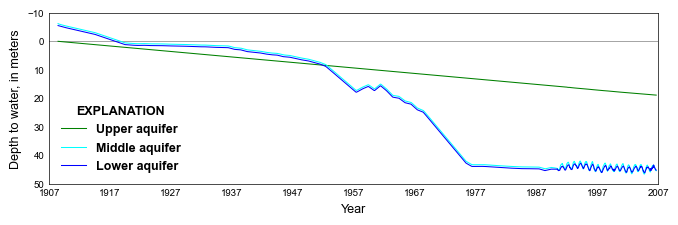

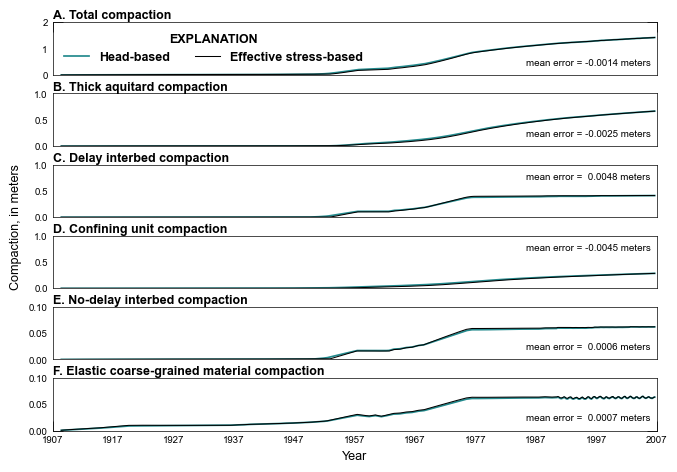

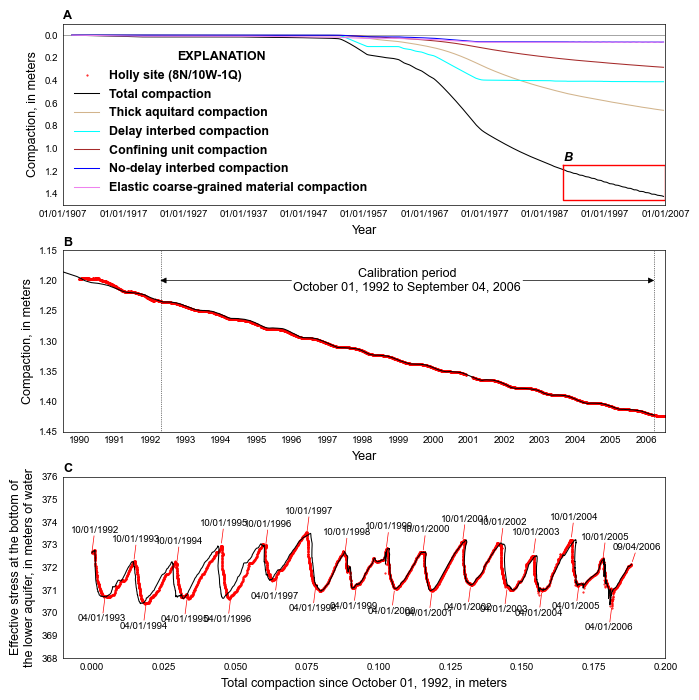

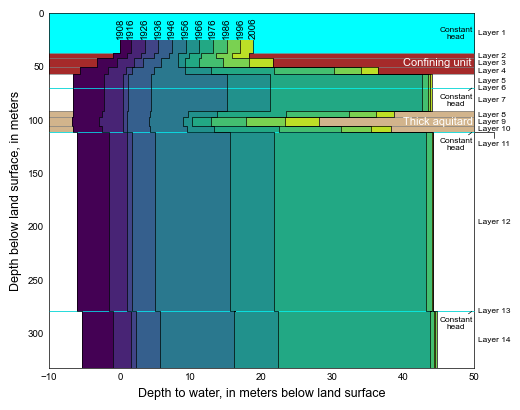

In [8]:
if plot:
    plot_results()
    export_tables()